## Breast Cancer Prediction

In [1]:
# Import necessary packages
import os , glob 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import skimage
from skimage.io import imread , imread_collection 

from sklearn.metrics import accuracy_score , classification_report
from sklearn.preprocessing import LabelEncoder,StandardScaler

import keras
from keras.applications import mobilenet
from keras.layers import Dense ,Dropout
from keras.models import Sequential

Using TensorFlow backend.
/Users/chandramouliyalamanchili/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/chandramouliyalamanchili/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/chandramouliyalamanchili/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [2]:
images_path ='../Data/Images/*/'
patient_list = list(glob.glob(images_path))
print('Number of the patient :{}'.format(str(len(patient_list))))

sum = 0
for i in range(0 , len(patient_list)):
    sum+=len(glob.glob(patient_list[i]+'/*/*'))
print('Number of the images :{}'.format(sum))

Number of the patient :280
Number of the images :278082


In [3]:
test=[glob.glob(patient_list[i]+'/*/*') for i in range(0,len(patient_list))]

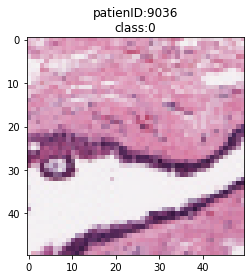

In [4]:
img_sample = imread(test[0][0])
plt.title('patienID:'
          +str(test[0][0].split('/')[3])+'\n'
         'class:'+str(test[0][0].split('/')[4]))
plt.imshow(img_sample)

In [5]:
patient_ID = [test[i][x].split('/')[3]for i in range(0,len(test))for x in range(0,len(test[i]))]
class_test = [test[i][x].split('/')[4]for i in range(0,len(test))for x in range(0 ,len(test[i]))]
patient_pathes = [test[i][x]for i in range(0,len(test))for x in range(0,len(test[i]))]

In [6]:
d = {'patient_ID':patient_ID,'pathes':patient_pathes,'diagnosis':class_test}
BC_df = pd.DataFrame(data=d)

In [7]:
print('The shape of our datset:'+" "+str(BC_df.shape))
BC_df.head()

The shape of our datset: (278082, 3)


,patient_ID,pathes,diagnosis
0,9036,../Data/Images/9036/0/9036_idx5_x1051_y2401_cl...,0
1,9036,../Data/Images/9036/0/9036_idx5_x2951_y951_cla...,0
2,9036,../Data/Images/9036/0/9036_idx5_x3001_y1451_cl...,0
3,9036,../Data/Images/9036/0/9036_idx5_x3051_y801_cla...,0
4,9036,../Data/Images/9036/0/9036_idx5_x951_y1901_cla...,0


In [8]:
BC_df = BC_df[(BC_df['diagnosis']=='0')|(BC_df['diagnosis']=='1')]  

In [9]:
print('The shape of new edited BC_df csv :'+' '+str(BC_df.shape))


The shape of new edited BC_df csv : (277524, 3)


In [10]:
BC_df['diagnosis'].value_counts()

0    198738
1     78786
Name: diagnosis, dtype: int64

In [12]:
BC_copy_1 = BC_df.iloc[:20000,:]
from PIL.Image import open
BC_copy_1['pixels'] =  BC_copy_1['pathes'].map(lambda x:np.asarray(open(x).resize((224,224))).astype(np.float32))

/Users/chandramouliyalamanchili/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
BC_copy_1['pixels'] = BC_copy_1['pixels'].tolist()
BC_copy_1.head()

/Users/chandramouliyalamanchili/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,patient_ID,pathes,diagnosis,pixels
0,9036,../Data/Images/9036/0/9036_idx5_x1051_y2401_cl...,0,"[[[229.0, 193.0, 212.0], [229.0, 193.0, 212.0]..."
1,9036,../Data/Images/9036/0/9036_idx5_x2951_y951_cla...,0,"[[[209.0, 167.0, 198.0], [209.0, 167.0, 198.0]..."
2,9036,../Data/Images/9036/0/9036_idx5_x3001_y1451_cl...,0,"[[[236.0, 222.0, 232.0], [236.0, 222.0, 232.0]..."
3,9036,../Data/Images/9036/0/9036_idx5_x3051_y801_cla...,0,"[[[143.0, 110.0, 153.0], [143.0, 110.0, 153.0]..."
4,9036,../Data/Images/9036/0/9036_idx5_x951_y1901_cla...,0,"[[[226.0, 169.0, 195.0], [226.0, 169.0, 195.0]..."


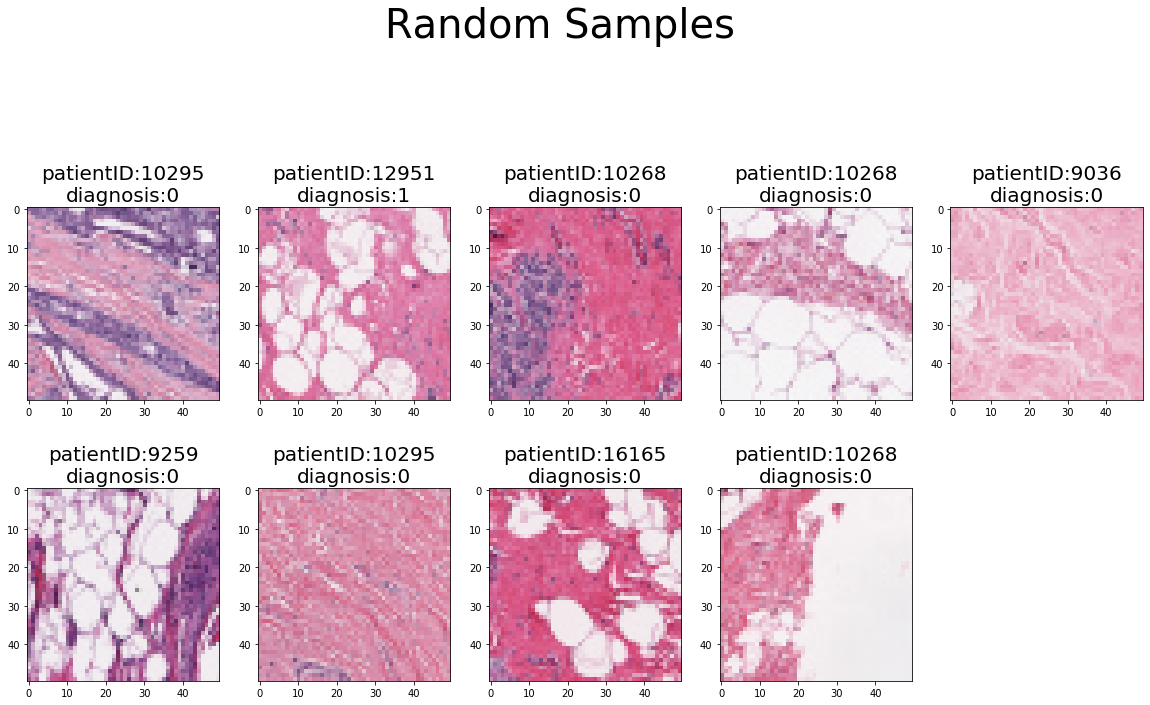

In [14]:
from random import choice
fig,axes = plt.subplots(figsize=(20,25))
  
ran_sample = [choice(BC_copy_1['pathes'])for x in range(0,10) ]
for i in range(0,len(ran_sample)):
    img = imread(ran_sample[i])
    plt.imshow(img)
    axes =plt.subplot(5,5,i+1)
    axes.set_title('patientID:'+str(ran_sample[i].split('/')[3])+'\n'
                   +'diagnosis:'+str(ran_sample[i].split('/')[4]),fontsize=20)

# There was a blank plot 
# so remove it via 'delaxes'
fig.delaxes(axes)
fig.suptitle('Random Samples ',fontsize=40)
plt.show() 

0    16051
1     3949
Name: diagnosis, dtype: int64


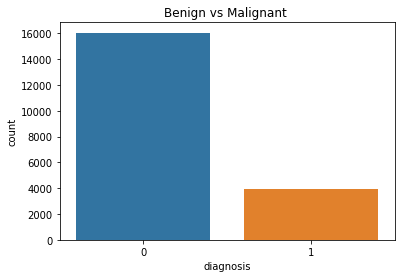

The difference between benign and malignant : 12102


In [15]:
BC_count = BC_copy_1['diagnosis'].value_counts()
print(BC_count)
sns.countplot(BC_copy_1['diagnosis'])
plt.title('Benign vs Malignant ')
plt.show()
print('The difference between benign and malignant :'+" "
      +str(BC_count[0]-BC_count[1]))

## Modeling

In [4]:
# Set generic vairbales
# Set parameters for splitting the input data
images_path ='../Data/Images-Model'
BASE_PATH = "../Data"
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])
TRAIN_SPLIT = 0.6
VAL_SPLIT = 0.2

In [38]:
from imutils import paths
import random, shutil, os
import subprocess, sys
# Load the input data for modeling



#cmd=None
#if sys.platform.startswith("darwin"): cmd=['cp', source, dest]
#elif sys.platform.startswith("win"): cmd=['xcopy', source, dest, '/K/O/X']

def copyWithSubprocess(source, dest):  
    # Use below cmd for windows
    # cmd=['xcopy', source, dest, '/K/O/X']
    cmd=['cp', source, dest]
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    proc.stdout.close()
    proc.stderr.close()
    
    
# Split the data now
originalPaths=list(paths.list_images(images_path))
random.seed(7)
random.shuffle(originalPaths)
index=int(len(originalPaths)*0.6)
trainPaths=originalPaths[:index]
testPaths=originalPaths[index:]
index=int(len(trainPaths)*0.2)
valPaths=trainPaths[:index]
trainPaths=trainPaths[index:]
datasets=[("training", trainPaths, TRAIN_PATH),
          ("validation", valPaths, VAL_PATH),
          ("testing", testPaths, TEST_PATH)
]
for (setType, originalPaths, basePath) in datasets:    
    print(f'Building {setType} set')
    if not os.path.exists(basePath):
        print(f'Building directory {basePath}')
        os.makedirs(basePath)
    for path in originalPaths:
        file=path.split(os.path.sep)[-1]
        label=file[-5:-4]
        labelPath=os.path.sep.join([basePath,label])        
        if not os.path.exists(labelPath):
            print(f'Building directory {labelPath}')
            os.makedirs(labelPath)
        newPath=os.path.sep.join([labelPath, file])
        #shutil.copy2(path, newPath)
        copyWithSubprocess(path,newPath)

Building training set
Building directory ../Data/training
Building directory ../Data/training/0
Building directory ../Data/training/1
Building validation set
Building directory ../Data/validation
Building directory ../Data/validation/0
Building directory ../Data/validation/1
Building testing set
Building directory ../Data/testing
Building directory ../Data/testing/1
Building directory ../Data/testing/0


In [2]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

height=48
width=48
depth=3
classes=2

# Build model
model=Sequential()
shape=(height,width,depth)
channelDim=-1
if K.image_data_format()=="channels_first":
    shape=(depth,height,width)
    channelDim=1      
model.add(SeparableConv2D(32, (3,3), padding="same",input_shape=shape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(SeparableConv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(SeparableConv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(SeparableConv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(SeparableConv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(SeparableConv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(classes))
model.add(Activation("softmax"))

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# Get the data ready for modeling
import matplotlib
matplotlib.use("Agg")
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adagrad
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

NUM_EPOCHS=20
INIT_LR=1e-2
BS=32

trainPaths=list(paths.list_images(TRAIN_PATH))
lenTrain=len(trainPaths)
lenVal=len(list(paths.list_images(VAL_PATH)))
lenTest=len(list(paths.list_images(TEST_PATH)))

trainLabels=[int(p.split(os.path.sep)[-2]) for p in trainPaths]
trainLabels=np_utils.to_categorical(trainLabels)
classTotals=trainLabels.sum(axis=0)
classWeight=classTotals.max()/classTotals

trainAug = ImageDataGenerator(
  rescale=1/255.0,
  rotation_range=20,
  zoom_range=0.05,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.05,
  horizontal_flip=True,
  vertical_flip=True,
  fill_mode="nearest")
valAug=ImageDataGenerator(rescale=1 / 255.0)
trainGen = trainAug.flow_from_directory(
  TRAIN_PATH,
  class_mode="categorical",
  target_size=(48,48),
  color_mode="rgb",
  shuffle=True,
  batch_size=BS)
valGen = valAug.flow_from_directory(
  VAL_PATH,
  class_mode="categorical",
  target_size=(48,48),
  color_mode="rgb",
  shuffle=False,
  batch_size=BS)
testGen = valAug.flow_from_directory(
  TEST_PATH,
  class_mode="categorical",
  target_size=(48,48),
  color_mode="rgb",
  shuffle=False,
  batch_size=BS)

Found 24080 images belonging to 2 classes.
Found 6019 images belonging to 2 classes.
Found 20067 images belonging to 2 classes.


In [ ]:
# Train the model
opt=Adagrad(lr=INIT_LR,decay=INIT_LR/NUM_EPOCHS)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])

M=model.fit_generator(
  trainGen,
  steps_per_epoch=lenTrain//BS,
  validation_data=valGen,
  validation_steps=lenVal//BS,
  class_weight=classWeight,
  epochs=NUM_EPOCHS)

# Let's see how our model performed
testGen.reset()
pred_indices=model.predict_generator(testGen,steps=(lenTest//BS)+1)
pred_indices=np.argmax(pred_indices,axis=1)
print(classification_report(testGen.classes, pred_indices, target_names=testGen.class_indices.keys()))
cm=confusion_matrix(testGen.classes,pred_indices)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
specificity=cm[1,1]/(cm[1,0]+cm[1,1])
sensitivity=cm[0,0]/(cm[0,0]+cm[0,1])
print(cm)
print(f'Accuracy: {accuracy}')
print(f'Specificity: {specificity}')
print(f'Sensitivity: {sensitivity}')
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), M.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), M.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), M.history["acc"], label="train_acc")
plt.plot(np.arange(0,N), M.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on the IDC Dataset")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot.png')

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
752/752 [==============================] - 1039s 1s/step - loss: 0.4293 - accuracy: 0.8382 - val_loss: 0.6186 - val_accuracy: 0.8441
Epoch 2/20
752/752 [==============================] - 1047s 1s/step - loss: 0.3591 - accuracy: 0.8535 - val_loss: 0.2624 - val_accuracy: 0.8415
Epoch 3/20
752/752 [==============================] - 919s 1s/step - loss: 0.3399 - accuracy: 0.8594 - val_loss: 0.9951 - val_accuracy: 0.8642
Epoch 4/20
752/752 [==============================] - 842s 1s/step - loss: 0.3300 - accuracy: 0.8593 - val_loss: 1.2504 - val_accuracy: 0.8714
Epoch 5/20
752/752 [==============================] - 956s 1s/step - loss: 0.3220 - accuracy: 0.8668 - val_loss: 2.4303 - val_accuracy: 0.8739
Epoch 6/20
752/752 [==============================] - 992s 1s/step - loss: 0.3125 - accuracy: 0.8688 - val_loss: 0.6368 - val_accuracy: 0.8732
Epoch 7/20
752/752 [==============================] - 1017s 1s/step - loss: 0.3089 - accurac